In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random as random

In [6]:

# Load Data
df = pd.read_csv('/content/drive/MyDrive/Pokemon.csv')
df2 = df.copy()


df['Type 2'] = df['Type 2'].fillna('None')
stats_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
stat_min = df[stats_cols].min().values
stat_max = df[stats_cols].max().values
# print(df.groupby(['Type 2']).size())
# Save original labels
type1_labels = df['Type 1'].astype('category').cat.categories.tolist()
type2_labels = df['Type 2'].astype('category').cat.categories.tolist()
# print(type1_labels)
# print(type2_labels)
# Encode types
df['Type1_idx'] = df['Type 1'].astype('category').cat.codes
df['Type2_idx'] = df['Type 2'].astype('category').cat.codes
# print(df['Type1_idx'])
# print(df['Type2_idx'])
# Normalize stats
scaler = MinMaxScaler()
df[stats_cols] = scaler.fit_transform(df[stats_cols])

In [7]:
class PokemonDataset(Dataset):
    def __init__(self, df):
        self.stats = df[stats_cols].values.astype(np.float32)
        self.type1 = df['Type1_idx'].values.astype(np.int64)
        self.type2 = df['Type2_idx'].values.astype(np.int64)

    def __len__(self):
        return len(self.stats)

    def __getitem__(self, idx):
        return self.stats[idx], self.type1[idx], self.type2[idx]

dataset = PokemonDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [8]:
class VAE(nn.Module):
    def __init__(self, stat_dim=6, type1_dim=18, type2_dim=19, latent_dim=16):
        super(VAE, self).__init__()
        input_dim = stat_dim + type1_dim + type2_dim
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc21 = nn.Linear(64, latent_dim)
        self.fc22 = nn.Linear(64, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 64)
        self.fc_stat = nn.Linear(64, stat_dim)
        self.fc_type1 = nn.Linear(64, type1_dim)
        self.fc_type2 = nn.Linear(64, type2_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      h3 = F.relu(self.fc3(z))
      stats = F.relu(self.fc_stat(h3))  # Ensure non-negative stats
      type1 = self.fc_type1(h3)         # Use raw logits for softmax later
      type2 = self.fc_type2(h3)
      return stats, type1, type2


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [9]:
def loss_function(stats_pred, type1_pred, type2_pred, type1, type2, stats, mu, logvar):
    recon_loss_stat = F.mse_loss(stats_pred, stats, reduction='sum')
    loss_type1 = F.cross_entropy(type1_pred, type1, reduction='sum')
    loss_type2 = F.cross_entropy(type2_pred, type2, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # stat_mean_penalty = torch.mean(stats_pred ** 2)  # L2 penalty on stats
    return recon_loss_stat + loss_type1 + loss_type2 + KLD

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

losses = []
epochs = 100

for epoch in range(epochs):
    total_loss = 0
    for stats, type1, type2 in dataloader:
        stats = stats.to(device)
        type1 = type1.to(device)
        type2 = type2.to(device)
        type1_onehot = F.one_hot(type1, num_classes=18).float()
        type2_onehot = F.one_hot(type2, num_classes=19).float()
        x = torch.cat([stats, type1_onehot, type2_onehot], dim=1)
        optimizer.zero_grad()
        (stat_pred, type1_pred, type2_pred), mu, logvar = vae(x)
        loss = loss_function(stat_pred, type1_pred, type2_pred, type1, type2, stats, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
    avg_loss = total_loss / len(dataset)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.2f}")

Epoch 1, Loss: 6.22
Epoch 2, Loss: 5.62
Epoch 3, Loss: 5.28
Epoch 4, Loss: 5.09
Epoch 5, Loss: 5.02
Epoch 6, Loss: 4.99
Epoch 7, Loss: 4.96
Epoch 8, Loss: 4.94
Epoch 9, Loss: 4.94
Epoch 10, Loss: 4.96
Epoch 11, Loss: 4.95
Epoch 12, Loss: 4.92
Epoch 13, Loss: 4.93
Epoch 14, Loss: 4.92
Epoch 15, Loss: 4.93
Epoch 16, Loss: 4.94
Epoch 17, Loss: 4.93
Epoch 18, Loss: 4.90
Epoch 19, Loss: 4.91
Epoch 20, Loss: 4.93
Epoch 21, Loss: 4.92
Epoch 22, Loss: 4.89
Epoch 23, Loss: 4.92
Epoch 24, Loss: 4.93
Epoch 25, Loss: 4.89
Epoch 26, Loss: 4.93
Epoch 27, Loss: 4.92
Epoch 28, Loss: 4.92
Epoch 29, Loss: 4.91
Epoch 30, Loss: 4.91
Epoch 31, Loss: 4.94
Epoch 32, Loss: 4.93
Epoch 33, Loss: 4.92
Epoch 34, Loss: 4.94
Epoch 35, Loss: 4.91
Epoch 36, Loss: 4.91
Epoch 37, Loss: 4.89
Epoch 38, Loss: 4.91
Epoch 39, Loss: 4.90
Epoch 40, Loss: 4.90
Epoch 41, Loss: 4.91
Epoch 42, Loss: 4.90
Epoch 43, Loss: 4.91
Epoch 44, Loss: 4.90
Epoch 45, Loss: 4.91
Epoch 46, Loss: 4.90
Epoch 47, Loss: 4.91
Epoch 48, Loss: 4.90
E

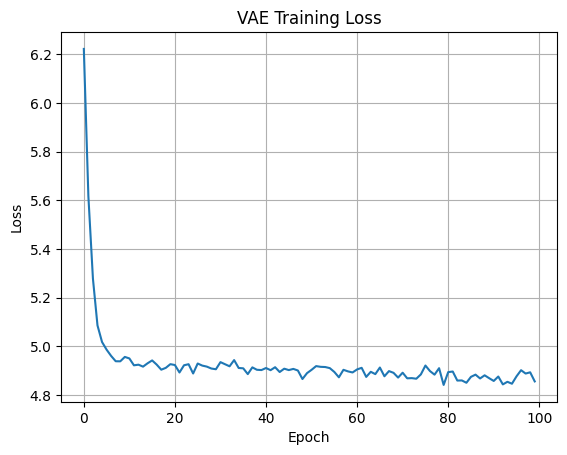

In [11]:
plt.plot(losses)
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [12]:
vae.eval()
generated = []

for _ in range(100):
    with torch.no_grad():
        z = torch.randn(1, 16).to(device)
        stat_pred, type1_pred, type2_pred = vae.decode(z)
        stat_pred = stat_pred.cpu().numpy().squeeze()
        stat_pred = scaler.inverse_transform(stat_pred.reshape(1, -1)).flatten()
        # stat_pred = np.clip(stat_pred, df[stats_cols].min().values, df[stats_cols].max().values)
        type1 = torch.argmax(F.softmax(type1_pred, dim=1)).item()
        type2 = torch.argmax(F.softmax(type2_pred, dim=1)).item()
        # print(type1, t)
        generated.append({
            'HP': stat_pred[0],
            'Attack': stat_pred[1],
            'Defense': stat_pred[2],
            'Sp. Atk': stat_pred[3],
            'Sp. Def': stat_pred[4],
            'Speed': stat_pred[5],
            'Type 1': type1_labels[type1],
            'Type 2': type2_labels[type2]
        })

gen_df = pd.DataFrame(generated)
# print(gen_df.groupby(['Type 1']).size())
gen_df


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1,Type 2
0,68.071472,80.111816,73.119499,77.174339,77.266174,71.426994,Normal,None
1,72.182884,81.086960,77.327942,78.571396,76.513794,69.264038,Fire,None
2,71.015198,77.962219,78.568642,73.794037,76.899261,60.929905,Water,None
3,74.159401,81.777580,81.619865,75.820229,75.397629,68.338348,Water,None
4,66.681595,71.180229,65.689934,69.531715,69.587677,65.307571,Normal,None
...,...,...,...,...,...,...,...,...
95,73.877647,89.133713,88.620972,76.220467,77.426064,66.647881,Water,None
96,70.962914,77.008865,71.649940,69.634888,71.221527,69.891121,Water,None
97,71.337685,79.827560,71.535446,74.545174,72.449463,64.287308,Grass,None
98,70.924927,78.214905,73.429642,75.321617,76.558258,64.402710,Normal,None


In [13]:
# Type Chart
type_chart = {
    'Normal': {'Rock': 0.5, 'Ghost': 0.0, 'Steel': 0.5},
    'Fire': {'Fire': 0.5, 'Water': 0.5, 'Grass': 2.0, 'Ice': 2.0, 'Bug': 2.0, 'Rock': 0.5, 'Dragon': 0.5, 'Steel': 2.0},
    'Water': {'Fire': 2.0, 'Water': 0.5, 'Grass': 0.5, 'Ground': 2.0, 'Rock': 2.0, 'Dragon': 0.5},
    'Electric': {'Water': 2.0, 'Electric': 0.5, 'Grass': 0.5, 'Ground': 0.0, 'Flying': 2.0, 'Dragon': 0.5},
    'Grass': {'Fire': 0.5, 'Water': 2.0, 'Grass': 0.5, 'Poison': 0.5, 'Ground': 2.0, 'Flying': 0.5, 'Bug': 0.5, 'Rock': 2.0, 'Dragon': 0.5, 'Steel': 0.5},
    'Ice': {'Fire': 0.5, 'Water': 0.5, 'Grass': 2.0, 'Ice': 0.5, 'Ground': 2.0, 'Flying': 2.0, 'Dragon': 2.0, 'Steel': 0.5},
    'Fighting': {'Normal': 2.0, 'Ice': 2.0, 'Poison': 0.5, 'Flying': 0.5, 'Psychic': 0.5, 'Bug': 0.5, 'Rock': 2.0, 'Ghost': 0.0, 'Dark': 2.0, 'Steel': 2.0, 'Fairy': 0.5},
    'Poison': {'Grass': 2.0, 'Poison': 0.5, 'Ground': 0.5, 'Rock': 0.5, 'Ghost': 0.5, 'Steel': 0.0, 'Fairy': 2.0},
    'Ground': {'Fire': 2.0, 'Electric': 2.0, 'Grass': 0.5, 'Poison': 2.0, 'Flying': 0.0, 'Bug': 0.5, 'Rock': 2.0, 'Steel': 2.0},
    'Flying': {'Electric': 0.5, 'Grass': 2.0, 'Fighting': 2.0, 'Bug': 2.0, 'Rock': 0.5, 'Steel': 0.5},
    'Psychic': {'Fighting': 2.0, 'Poison': 2.0, 'Psychic': 0.5, 'Dark': 0.0, 'Steel': 0.5},
    'Bug': {'Fire': 0.5, 'Grass': 2.0, 'Fighting': 0.5, 'Poison': 0.5, 'Flying': 0.5, 'Psychic': 2.0, 'Ghost': 0.5, 'Dark': 2.0, 'Steel': 0.5, 'Fairy': 0.5},
    'Rock': {'Fire': 2.0, 'Ice': 2.0, 'Fighting': 0.5, 'Ground': 0.5, 'Flying': 2.0, 'Bug': 2.0, 'Steel': 0.5},
    'Ghost': {'Normal': 0.0, 'Psychic': 2.0, 'Ghost': 2.0, 'Dark': 0.5},
    'Dragon': {'Dragon': 2.0, 'Steel': 0.5, 'Fairy': 0.0},
    'Dark': {'Fighting': 0.5, 'Psychic': 2.0, 'Ghost': 2.0, 'Dark': 0.5, 'Fairy': 0.5},
    'Steel': {'Fire': 0.5, 'Water': 0.5, 'Electric': 0.5, 'Ice': 2.0, 'Rock': 2.0, 'Steel': 0.5, 'Fairy': 2.0},
    'Fairy': {'Fire': 0.5, 'Fighting': 2.0, 'Poison': 0.5, 'Dragon': 2.0, 'Dark': 2.0, 'Steel': 0.5}
}

def get_multiplier(attacker, defender1, defender2='None'):
    m1 = type_chart.get(attacker, {}).get(defender1, 1.0)
    m2 = type_chart.get(attacker, {}).get(defender2, 1.0)
    return m1 + m2

def simulate_battle(poke1, poke2):
    hp1, hp2 = poke1['HP'], poke2['HP']
    speed1, speed2 = poke1['Speed'], poke2['Speed']
    is_special = random.choice([True, False])

    atk1 = poke1['Sp. Atk'] if is_special else poke1['Attack']
    def2 = poke2['Sp. Def'] if is_special else poke2['Defense']
    atk2 = poke2['Sp. Atk'] if is_special else poke2['Attack']
    def1 = poke1['Sp. Def'] if is_special else poke1['Defense']

    mult1 = get_multiplier(poke1['Type 1'], poke2['Type 1'], poke2['Type 2'])
    mult2 = get_multiplier(poke2['Type 1'], poke1['Type 1'], poke1['Type 2'])
    # print(mult1, mult2)
    # stab1 = 1.5 if poke1['Type 1'] in [poke1['Type 1'], poke1.get('Type 2')] else 1.0
    # stab2 = 1.5 if poke2['Type 1'] in [poke2['Type 1'], poke2.get('Type 2')] else 1.0

    damage1 = max(0, (atk1  * mult1 - def2))
    damage2 = max(0, (atk2  * mult2 - def1))
    # print(atk2  , mult2 , def1)
    if speed1 >= speed2:
        hp2 -= damage1
        if hp2 <= 0:
            return "Generated"
        hp1 -= damage2
        if hp1 <= 0:
            return "Real"
    else:
        hp1 -= damage2
        if hp1 <= 0:
            return "Real"
        hp2 -= damage1
        if hp2 <= 0:
            return "Generated"

    return "Draw"

# Simulate battles
results = {'Generated': 0, 'Real': 0, 'Draw': 0}
for _, gen_poke in gen_df.iterrows():
    real_poke = df2.sample(1).iloc[0]
    poke1 = {k: gen_poke[k] for k in stats_cols + ['Type 1', 'Type 2']}
    poke2 = {k: real_poke[k] for k in stats_cols + ['Type 1', 'Type 2']}
    result = simulate_battle(poke1, poke2)
    results[result] += 1

# Report
total = sum(results.values())
print(f"Validation Results (out of {total} battles):")
for key in results:
    print(f"{key} Wins: {results[key]} ({results[key]/total:.2%})")

Validation Results (out of 100 battles):
Generated Wins: 43 (43.00%)
Real Wins: 44 (44.00%)
Draw Wins: 13 (13.00%)
